In [1]:
import sys
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from pathlib import Path
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as assembly, master_domain
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 4: Vectorial Poisson Problem at Rectangular Domain $\Omega = [-1,1]^2$

Considere um problema vetorial de _Poisson_ 2D em $\Omega = [-1,1]^2$

$$
\nabla \times \nabla \times \mathbf{u}(\mathbf{x}) + a \mathbf{u}(\mathbf{x}) =
\mathbf{f}(\mathbf{x}) \quad \text{em} \; \Omega = [-1, 1]^2
\tag{1}
$$

$$
\hat{n} \times \mathbf{u} = 0 \quad \text{em} \; \partial \Omega
$$

onde a fonte é dada por,
$$
\mathbf{f}(x,y) = (2\pi^2 + 1)\, 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{2}
$$

A solução analítica deste problema é

$$
\mathbf{u}(x,y) = 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos de _Nedelec_ do tipo 1, $N_0$, em $R^2$ para resolver o Problema de Valor de Contorno vetorial $(1)$.

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
## Geometry and mesh Domain

In [2]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'entire_boundary'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]

# Create mesh from file geometry
h = 0.1
mesh_data = ps.create_meshed_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, view_mesh=False)

Malha salva em pre_processing/mesh/vectorial_poisson_domain_Triangle1.msh
Model vectorial_poisson (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 514 nodes in total
Info     : 946 2-D elements in total


# Figure 1: Vectorial Shape Functions at Master Domain

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pre_processing\pictures\nedelec_shape_functions_n0.svg


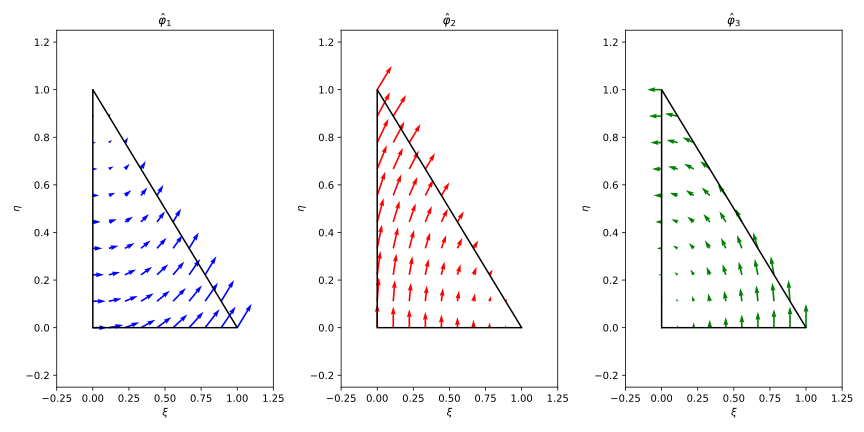

In [3]:
ps.plot_shape_functions_n0()
display(SVG(filename="pre_processing/pictures/nedelec_shape_functions_n0.svg"))

# Figure 2: Meshed domain

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pre_processing\pictures\meshed_domain_Triangle1_InterpolateDomain.svg


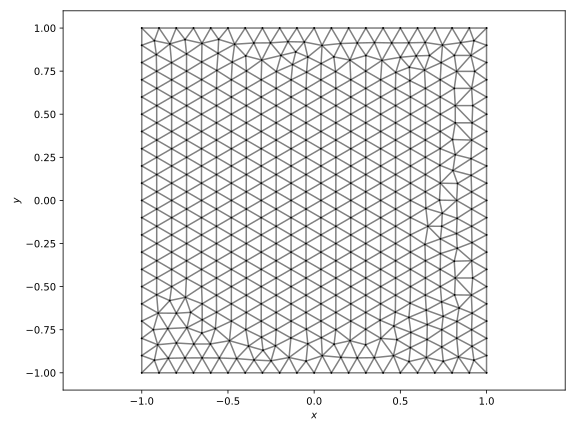

In [4]:
if h in [2, 1]:
    graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, name='Interpolate', numbering=True, show_edges=True)
else:
    graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, name='Interpolate')
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_InterpolateDomain.svg"))

# Structured data

In [5]:
mesh_data['edges'][1]

{'conn': [1, 5],
 'bc': {'tag': 101,
  'type': 'Dirichlet',
  'value': 0.0,
  'name': 'contour_domain'},
 'len': 0.09999999999972264}

In [6]:
mesh_data['cell'][1]

{'conn': [461, 418, 492],
 'conn_sorted': [418, 461, 492],
 'conn_edge': [81, 82, 83],
 'geo': {'centroid': (-0.10578763086092084, -0.8469817622930408),
  'area': 0.005738971608181527},
 'contour': {'type': None, 'conn_contour': None},
 'material': {'tag': 201, 'name': 'free_space', 'a_constant': 1},
 'stiffness_term': [array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]])],
 'mass_term': [1, 1, 1, 1, 1, 1, 1],
 'source': [array([[-9.06542861],
         [-5.99943814]]),
  array([[-10.64434446],
         [ -4.86355892]]),
  array([[-8.04336257],
         [-5.50822705]]),
  array([[-8.42397522],
         [-7.59226699]]),
  array([[-6.32052127],
         [-7.95870719]]),
  array([[-10.61745925],
         [ -6.65592988]]),
  array([[-10.0240538 ],
         [ -3.26418313]

In [7]:
conn_edge_data = {key: cell['conn_edge'] for key, cell in mesh_data['cell'].items()}
conn_edge_data[1]

[81, 82, 83]

# Degree Of Freedom (Dofs)

In [8]:
curl_u = ps.curl_u_at_domain(mesh_data)

# Solution at each element

In [9]:
# u_at_cell = ps.interpolate_solution(mesh_data, curl_u, xik_master=(1/3, 1/3))

In [14]:
# Ponto de Interpolação
xik_master=(1/3, 1/3)

# Dicionário para armazenar os potenciais vetoriais interpolados em cada célula
u_at_cell = {}

# Percorre cada célula da malha
for key, cell in mesh_data['cell'].items():    
    Je = assembly.vectorial_jacobian(mesh_data, cell)    
    JinvT = np.linalg.inv(Je).T
    phi_hat = master_domain.shape_functions_n0(*xik_master)
    u_at_cell[key] = 0

    # Interpolação dos potenciais vetoriais em cada célula
    for i, edge in enumerate(cell['conn_edge']):
        le = mesh_data['edges'][edge]['len']
        u_at_cell[key] += curl_u[edge] * (JinvT @ phi_hat[i])
        

# Interpolation of Analytical Solution 

## Figure 3: Analytical solution interpolate at $\partial{\Omega_c}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pos_processing\pictures\solution_interpolate_at_contour.svg


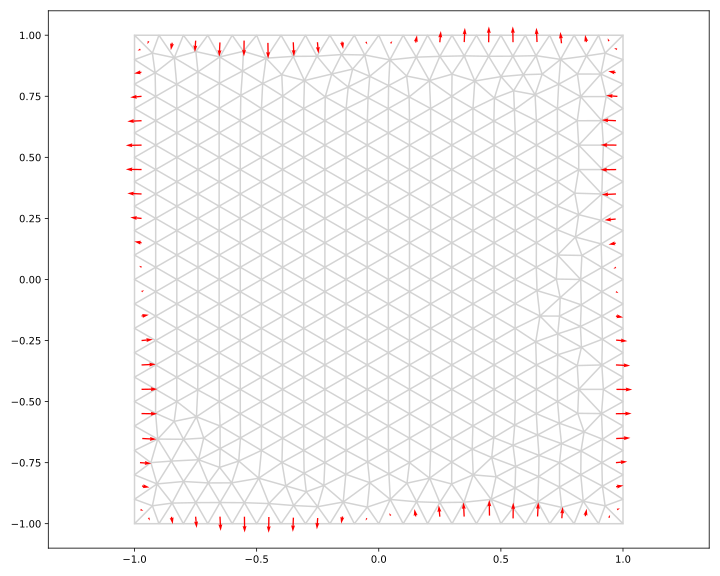

In [15]:
# Extraindo as coordenadas globais dos nós (x, y) e a matriz de conectividade
xg, yg, conn_py = graph_results.structured_data(mesh_data)

# Criando a malha
plt.figure(figsize=(10, 8))
plt.triplot(xg, yg, conn_py, color='lightgray')

# Adicionando os vetores ao gráfico
for key, cell in mesh_data['cell'].items():
    if cell['contour']['type'] == 'Dirichlet':        
        xc, yc = cell['geo']['centroid']
        ux, uy = u_at_cell[key][0], u_at_cell[key][1]
        plt.quiver(xc, yc, ux, uy,
                    angles='xy', scale_units='xy', scale=15, color='r', width=0.002)

plt.axis('equal')
plt.tight_layout()

# Salvando o arquivo no formato SVG
filepath = graph_results.get_dir(f"pos_processing/pictures/solution_interpolate_at_contour.svg")
plt.savefig(filepath, format="svg")
plt.close()
print(f"Arquivo salvo em: {filepath}")
display(SVG(filename="pos_processing/pictures/solution_interpolate_at_contour.svg"))

## Figure 4: Analytical solution interpolate at $\Omega_c$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pos_processing\pictures\solution_interpolate_at_omegac.svg


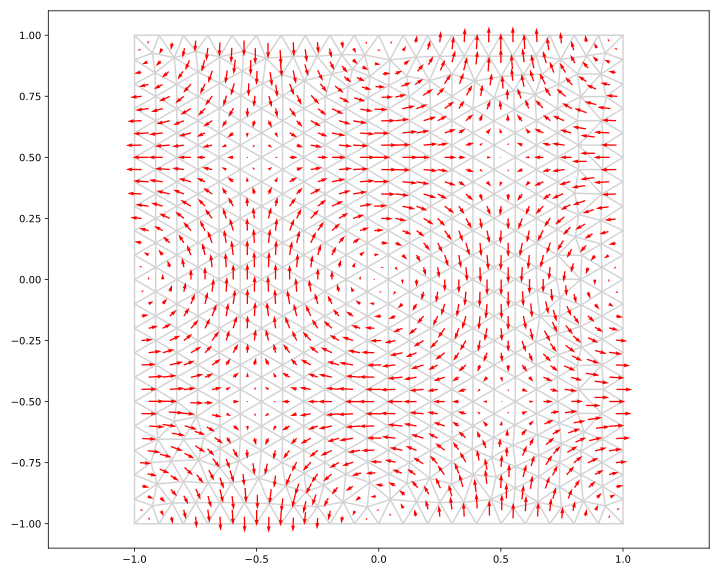

In [17]:
# Criando a malha
plt.figure(figsize=(10, 8))
plt.triplot(xg, yg, conn_py, color='lightgray')

# Adicionando os vetores ao gráfico
for key, cell in mesh_data['cell'].items():
    xc, yc = cell['geo']['centroid']
    ux, uy = u_at_cell[key][0], u_at_cell[key][1]
    plt.quiver(xc, yc, ux, uy,
                angles='xy', scale_units='xy', scale=15, color='r', width=0.002)

plt.axis('equal')
plt.tight_layout()

# Salvando o arquivo no formato SVG
filepath = graph_results.get_dir(f"pos_processing/pictures/solution_interpolate_at_omegac.svg")
plt.savefig(filepath, format="svg")
plt.close()
print(f"Arquivo salvo em: {filepath}")
display(SVG(filename="pos_processing/pictures/solution_interpolate_at_omegac.svg"))

## Figure 5: Analytical solution at $\Omega_c$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pos_processing\pictures\analytical_solution_at_omegac.svg
Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pos_processing\pictures\source_at_omegac.svg


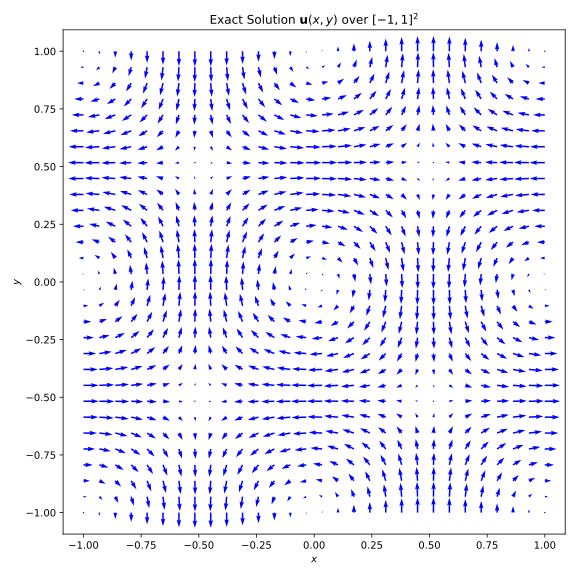

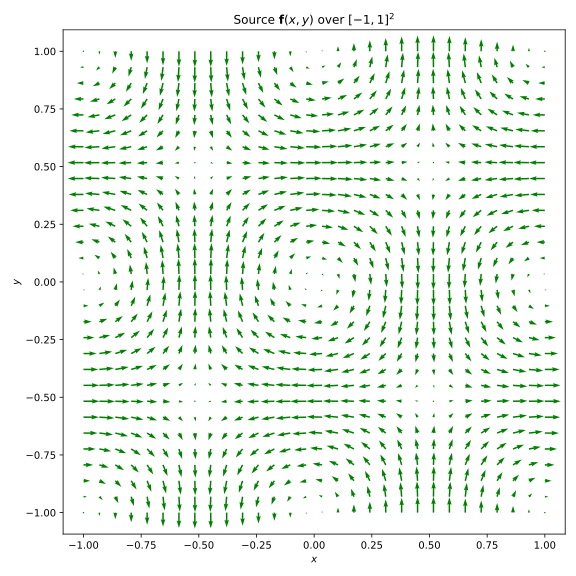

In [ ]:
ps.plot_analytical_solution()
display(SVG(filename="pos_processing/pictures/analytical_solution_at_omegac.svg"))
display(SVG(filename="pos_processing/pictures/source_at_omegac.svg"))

In [15]:
u_at_cell

{1: array([[-3.80029142],
        [-2.19183302]]),
 2: array([[-0.77363022],
        [ 6.85614268]]),
 3: array([[-1.28884673],
        [-6.203907  ]]),
 4: array([[-2.52155459],
        [-1.75959818]]),
 5: array([[8.4004442 ],
        [0.80400365]]),
 6: array([[8.2863683 ],
        [0.80147837]]),
 7: array([[-8.190724  ],
        [-0.82818198]]),
 8: array([[-8.35394237],
        [-0.88204647]]),
 9: array([[3.21638215],
        [5.65920932]]),
 10: array([[-6.36563193],
        [-1.43855593]]),
 11: array([[-6.46333402],
        [-2.28206364]]),
 12: array([[-8.09432818],
        [ 1.74112173]]),
 13: array([[-7.75817806],
        [ 1.99829929]]),
 14: array([[ 7.77828183],
        [-2.02849145]]),
 15: array([[ 8.10487772],
        [-1.74584701]]),
 16: array([[-2.06430796],
        [-5.4023727 ]]),
 17: array([[-1.28279347],
        [-6.2310123 ]]),
 18: array([[-7.28352426],
        [-1.85528217]]),
 19: array([[-8.26606331],
        [-1.81012971]]),
 20: array([[-6.32586171],


Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.